# Train Cellpose

1. Train the cellpose algorithm on segmented data created using e.g. the cellpose GUI. The cellpose algorithm was already trained on a general dataset containing various cells. Here, it was trained additionally on our specific celldata. This was found to enhance the performance, although it was already okay before.

2. After the training the cellpose algorithm can be run on a folder of input images to create annotation files that then be used for e.g. the Mask RCNN model. In this notebook also the option to run the cellpose algorithm without pretraining is implemented.

This code is based on https://colab.research.google.com/github/MouseLand/cellpose/blob/master/notebooks/Cellpose_2D_v0_1.ipynb

In [1]:
#Install Cellpose, configure dependencies and check GPU access
!pip install cellpose

#disabled installation and import of mxnet as pytorch is the default neural net
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
import shutil


print ("Downloading Models")
from cellpose import models

#https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

#Check if colab notebook instance has GPU access
if models.use_gpu()==False: 
  #Warnings from the ZeroCost StarDist notebook
  print(BOLD+UNDERLINE+'You do not have GPU access.'+END)
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')
  use_GPU=False
else:
  print(BOLD+UNDERLINE+"You have access to the GPU."+END+"\nDetails are:")
  print("*************************************************")
  !nvidia-smi
  use_GPU=True

print("*************************************************")
print("Libraries imported and configured")

     |████████████████████████████████| 13.2 MB 9.6 MB/s eta 0:00:01
  Created wheel for cellpose: filename=cellpose-0.6.1-py3-none-any.whl size=146566 sha256=c62fb56942512cfe2c828e43654222c30305585ab4612d9b56b61cf03a8d69aa
  Stored in directory: /root/.cache/pip/wheels/f5/a5/25/b1f9087c858f933f8c5349614d70f215295a683e63e3bfa703
Successfully built cellpose


Downloading: "https://www.cellpose.org/models/cyto_0" to /root/.cellpose/models/cyto_0
100%|██████████| 25.2M/25.2M [00:00<00:00, 26.9MB/s]
Downloading: "https://www.cellpose.org/models/cyto_1" to /root/.cellpose/models/cyto_1
100%|██████████| 25.2M/25.2M [00:01<00:00, 22.4MB/s]
Downloading: "https://www.cellpose.org/models/cyto_2" to /root/.cellpose/models/cyto_2
100%|██████████| 25.2M/25.2M [00:00<00:00, 27.1MB/s]
Downloading: "https://www.cellpose.org/models/cyto_3" to /root/.cellpose/models/cyto_3
100%|██████████| 25.2M/25.2M [00:00<00:00, 27.3MB/s]
Downloading: "https://www.cellpose.org/models/size_cyto_0.npy" to /root/.cellpose/models/size_cyto_0.npy
100%|██████████| 3.55k/3.55k [00:00<00:00, 2.88MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_0" to /root/.cellpose/models/cytotorch_0
100%|██████████| 25.3M/25.3M [00:01<00:00, 25.6MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_1" to /root/.cellpose/models/cytotorch_1
100%|██████████| 25.3M/25.3M [00:01

** TORCH CUDA version installed and working. **
You have access to the GPU.
Details are:
*************************************************
Sun Mar 28 09:07:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |   1193MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+----------------------------

In [2]:
#specify training directories

train_input_dir = "../input/labeled-images/labeled_images" 
train_save_dir = "/kaggle/working"

In [3]:
#Load images from training input directory

train_images=[]
train_masks=[]
count=0
for _, _, files in os.walk(train_input_dir):
    files.sort()
    for f in files:
        dat = np.load(train_input_dir + '/' + f, allow_pickle=True).item()
        train_images.append(dat['img'])
        train_masks.append(dat['masks'])
        count+=1
print('Loaded', count, 'images.')

Loaded 59 images.


(-0.5, 1103.5, 1103.5, -0.5)

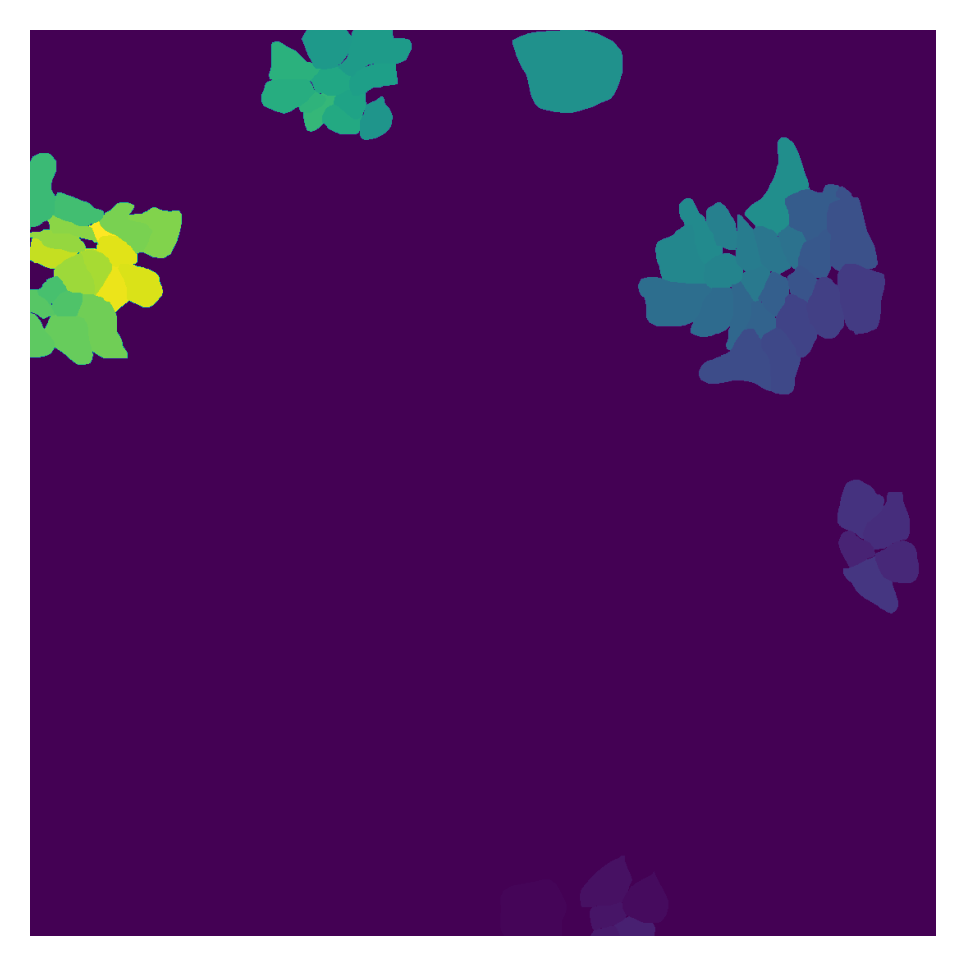

In [4]:
# show an example mask

plt.imshow(train_masks[2]); plt.axis('off')

(-0.5, 1103.5, 1103.5, -0.5)

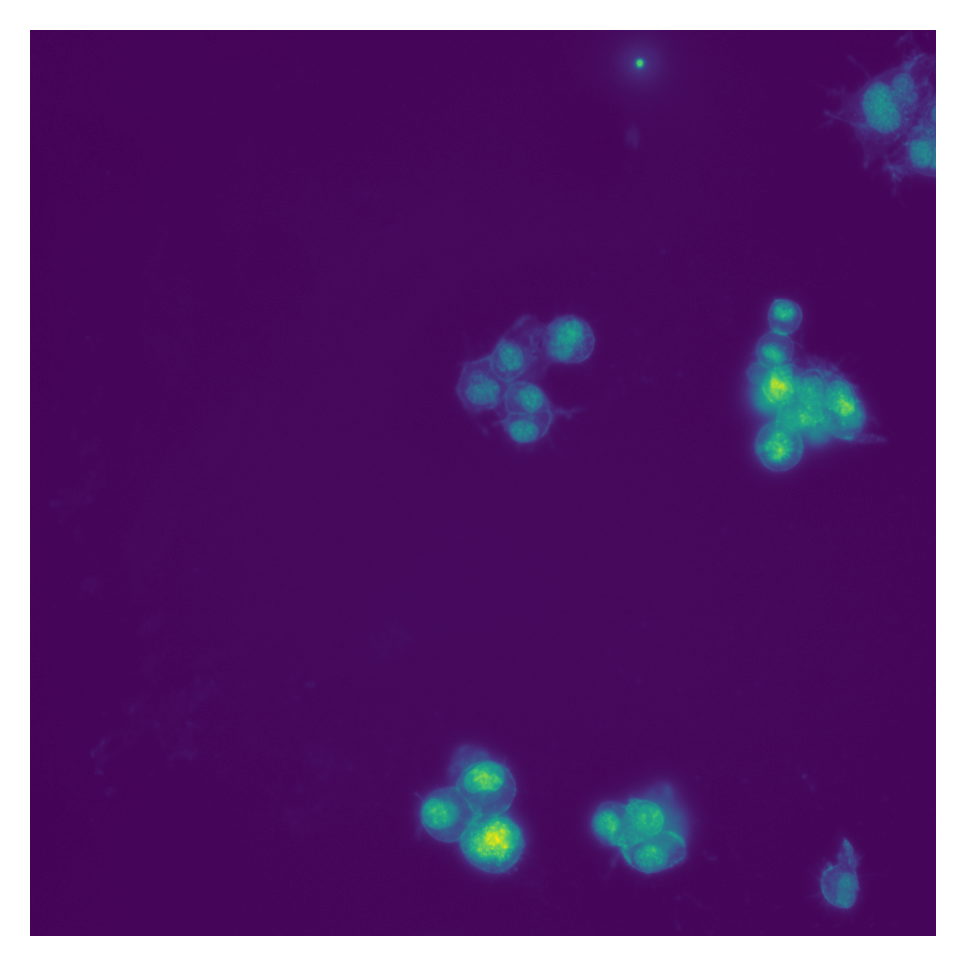

In [5]:
#and the corresponding image

image = dat['img']
plt.imshow(image[:,:]); plt.axis('off')

Define the model to start from:

In [6]:
#use cyto model provided by cellpose as a start

import pathlib
model_type="cyto"
cp_dir = pathlib.Path.home().joinpath('.cellpose')
model_dir = cp_dir.joinpath('models')

torch=True
torch_str = ['','torch'][torch]

old_pretrained_model=[os.fspath(model_dir.joinpath('%s%s_%d'%(model_type,torch_str,j))) for j in range(4)]

In [7]:
#use a beforehand created model as a start

old_pretrained_model='../input/old-weights-cellpose/cellpose_residual_on_style_on_concatenation_off_working_2021_03_07_08_07_33.837598'

# Training

In [8]:
#training based on old_pretrained_model and training data as defined above
#here alos hyperparameters such as learning_rate, number of epoch etc. can be specified

model=models.CellposeModel(pretrained_model=old_pretrained_model, diam_mean=50)
model.train(train_data=train_images, train_labels=train_masks, train_files=None, 
              test_data=None, test_labels=None, test_files=None,
              channels=[1,2], normalize=True, pretrained_model=old_pretrained_model, 
              save_path=train_save_dir, save_every=50,
              learning_rate=0.1, n_epochs=1, momentum=0.9, weight_decay=0.00001, batch_size=8, rescale=True)

parsing model string to get cellpose options
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **


  0%|          | 0/59 [00:00<?, ?it/s]

NOTE: test data not provided OR labels incorrect OR not same number of channels as train data
NOTE: computing flows for labels (could be done before to save time)


100%|██████████| 59/59 [01:27<00:00,  1.49s/it]


>>>> training network with 2 channel input <<<<
>>>> saving every 50 epochs
>>>> median diameter = 50
>>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00001
>>>> ntrain = 59
(2, 1104, 1104)
Epoch 0, Time 112.6s, Loss 0.4306, LR 0.0000
saving network parameters


'/kaggle/working/models/cellpose_residual_on_style_on_concatenation_off_working_2021_03_28_09_10_30.404515'

# Inference

Based on the above trained model check the performance and create the annotations used as input for the mask RCNN model.

For that first of all load the images.

In [9]:
#Directory path containing the images 
#Existing Masks directory will be deleted. (Does not read images in subfolders)
Input_Directory = "../input/cell-images/HEK_merg/HEK_merg" 
input_dir = os.path.join(Input_Directory, "") #adds separator to the end regardless if path has it or not

#Enter image extension here to read only files/images of specified extension (.tif,.jpg..) 
image_format = ".png"

save_dir = "/kaggle/working/annotations"

#Save Directory will be created in the input path under Masks


# r=root, d=directories, f = files
files=[]

for r, d, f in os.walk(input_dir):
    for fil in f:
      if (image_format):
        
        if fil.endswith(image_format):
          files.append(os.path.join(r, fil))
      else:
        files.append(os.path.join(r, fil))
    break #only read the root directory; can change this to include levels
files.sort()
if(len(files)==0):
  print("Number of images loaded: %d." %(len(files)))
  print("Cannot read image files. Check if folder has images")
else:
  print("Number of images loaded: %d." %(len(files)))

Number of images loaded: 2376.


No of images loaded are:  2376
Example Image:
HEK_2022_merged.png has 3 dimensions/s
Image: HEK_2022_merged.png


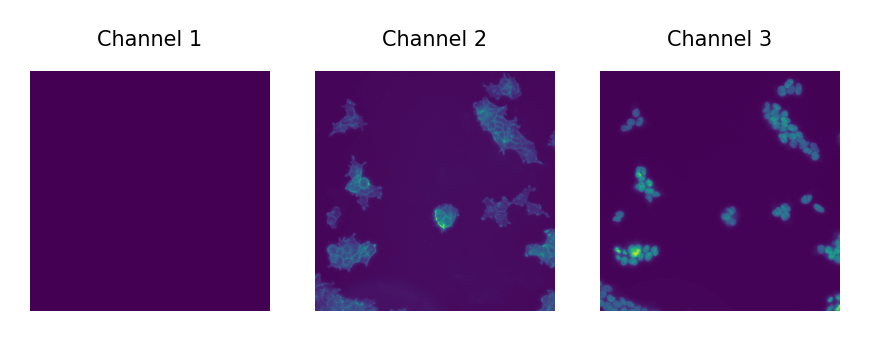

In [10]:
#Read and Load all the images
#Show a random image as an example

imgs=[] #store all images
#Read images
for f in files:
  im=skimage.io.imread(f)
  n_dim=len(im.shape) #shape of image
  dim=im.shape #dimensions of image
  channel=min(dim) #channel will be dimension with min value usually
  channel_position=dim.index(channel)
  #if no of dim is 3 and channel is first index, swap channel to last index
  if n_dim==3 and channel_position==0: 
    #print(dim)
    im=im.transpose(1,2,0)
    dim=im.shape
    #print("Shape changed")
  #print(dim)
  imgs.append(im)

nimg = len(imgs)
print("No of images loaded are: ", nimg)

print("Example Image:")

random_idx = random.choice(range(len(imgs)))
x=imgs[random_idx]
n_dim=len(x.shape)
file_name=os.path.basename(files[random_idx])
print(file_name+" has "+str(n_dim)+" dimensions/s")
if n_dim==3:
  channel_image=x.shape[2]
  fig, axs = plt.subplots(1, channel_image,figsize=(3,3))
  print("Image: %s" %(file_name))
  for channel in range(channel_image):
      axs[channel].imshow(x[:,:,channel])
      axs[channel].set_title('Channel '+str(channel+1),size=5)
      axs[channel].axis('off')
  fig.tight_layout()
elif n_dim==2:
  print("One Channel")
  plt.imshow(x)
else:
  print("Channel number invalid or dimensions wrong. Image shape is: "+str(x.shape))

In [11]:
#Use this if the original cellpose model has to be used instead of the pretrained one for the pretrained model skip this step

#If the image has only one channel, leave it as 0
segment_channel=0

model_type="cyto"

# Diameter of cell (pixels):
# Enter 0 if you don't know and cellpose will estimate it automatically. Can define this later as well.
diameter=0

# channels = [cytoplasm, nucleus]
channels=[segment_channel,0]

# DEFINE CELLPOSE MODEL
model = models.Cellpose(gpu=use_GPU, model_type=model_type)

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
if diameter is 0:
  diameter = None
  print("Diameter is set to None. The size of the cells will be estimated on a per image basis")

** TORCH CUDA version installed and working. **
>>>> using GPU
Diameter is set to None. The size of the cells will be estimated on a per image basis


In [12]:
# provide path for the pretrained model or use an old model instead
pretrained_model='./models/cellpose_residual_on_style_on_concatenation_off_working_2021_03_04_09_11_32.494127'

In [13]:
# create model to perform the inference
model2=models.CellposeModel(pretrained_model=old_pretrained_model, gpu=use_GPU, diam_mean=50)

parsing model string to get cellpose options
** TORCH CUDA version installed and working. **
>>>> using GPU


Image: HEK_0004_merged


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


time spent: running network 1.08s; flow+mask computation 3.56


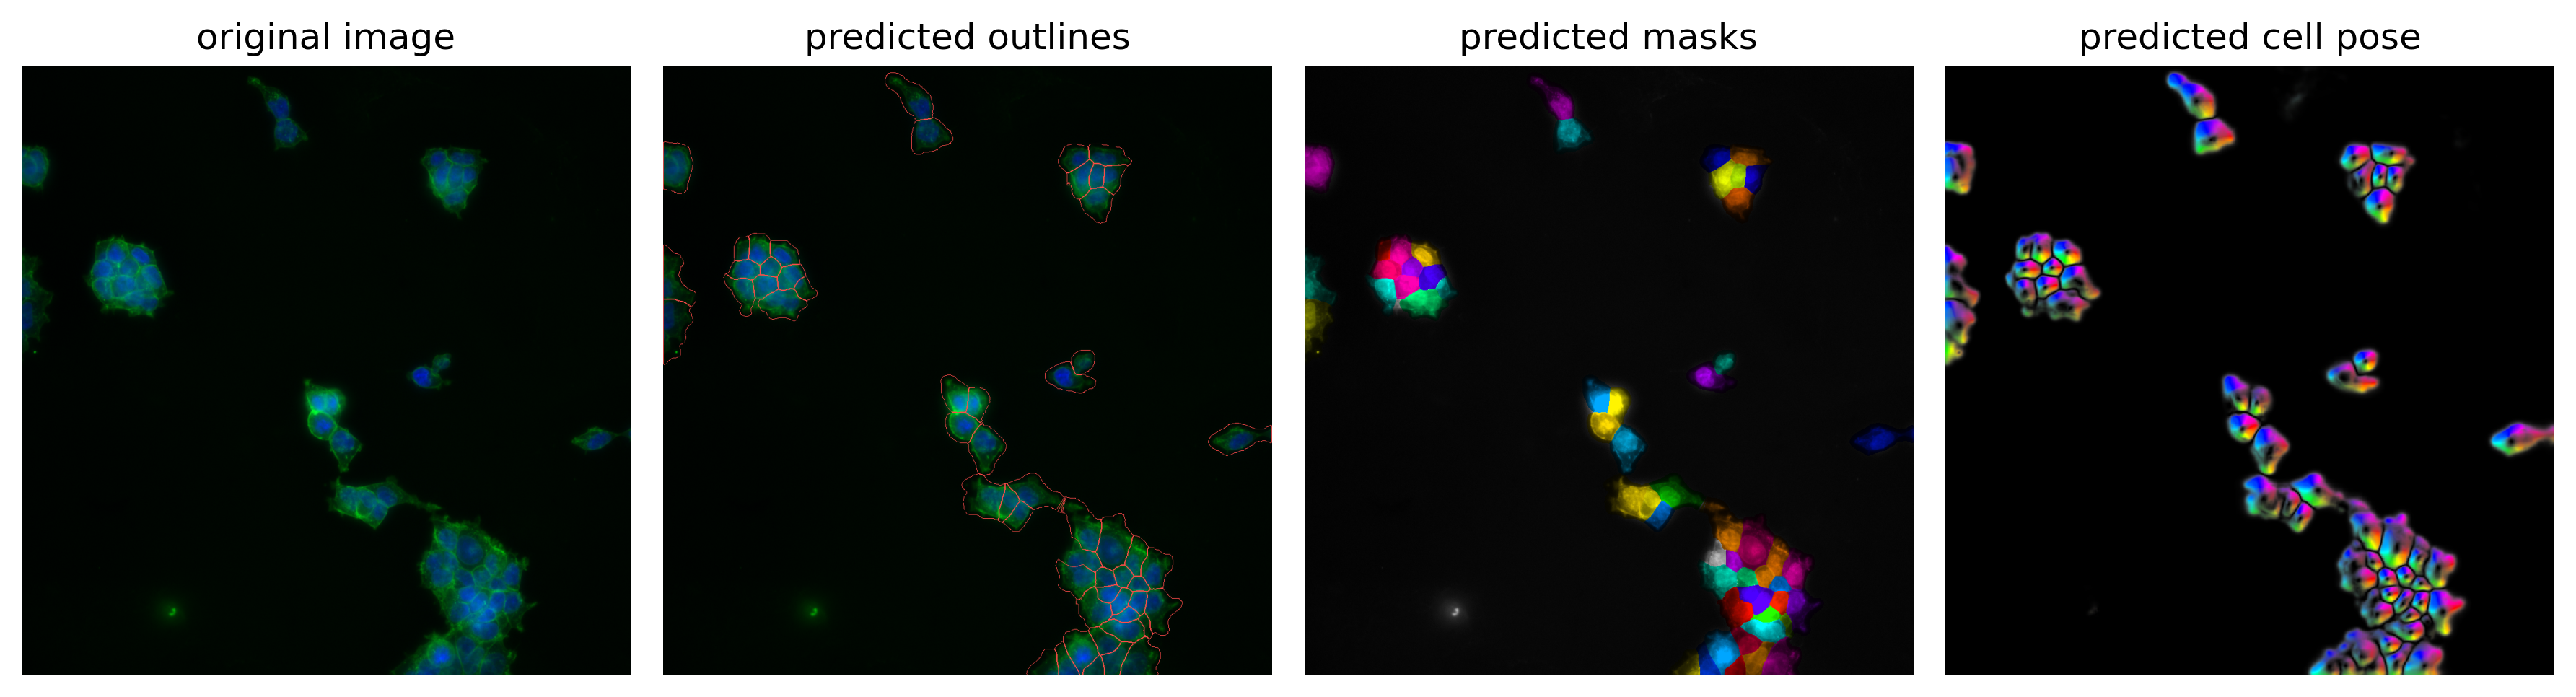

In [14]:
#test model an an example image
#this can also be used to test the parameters of the model i.e. flow_threshold and cellprob_threshold

from skimage.util import img_as_ubyte

Image_Number =  3 #note that this starts at zero (duh)
diameter = 50

flow_threshold = 0.75
cellprob_threshold = 0.0

if diameter is 0:
  diameter = None

try:
    image = imgs[Image_Number]
except IndexError as i:
   print("Image number does not exist",i)
   print("Actual no of images in folder: ",len(imgs))
print("Image: %s" %(os.path.splitext(os.path.basename(files[Image_Number]))[0]))
img1=imgs[Image_Number]

import cv2

masks, flows, styles = model2.eval(img1, diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, channels=[2,3])

# DISPLAY RESULTS
from cellpose import plot
maski = masks
flowi = flows[0]

#convert to 8-bit if not so it can display properly in the graph
if img1.dtype!='uint8':
  img1=img_as_ubyte(img1)

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img1, maski, flowi, channels=[2,3])
plt.tight_layout()
plt.show()

# Run on input images

Run the cellpose algorithm on the images loaded above to create annotation files. These consist of a binary mask for every detected cell and merged image containing all binary images. 

In [15]:
#define channels (again if not done above)
segment_channel = 2
nucleus_channel = 3

channels = [2,3]

In [16]:
#create output directories
os.makedirs('../working/annotations')
os.makedirs('../working/annotations/mergeMasks')

Run cellpose on the images loaded above and save the annotations created in this way.

In [17]:
#Run Cellpose on folder of images
from cellpose import utils
from skimage.util import img_as_ubyte
from tqdm import tqdm
import time

print("Running segmentation on channel %s" %(segment_channel))
if diameter is None:
  print("Diameter will be estimated from the image/s")
else:
  print(f"Cellpose will use a diameter of {diameter}")

print(f"Using a flow threshold of: {flow_threshold} and a cell probability threshold of: {cellprob_threshold}")

batch_size = 20

#evaluation has to be done in batches due to RAM restrictions
#the commented bound in the line below is used if all images have to be annotated
for i in range(1): #(len(imgs)//batch_size + 1):
  print("\n**********","BATCH NUMBER:",i+1,'/',len(imgs)//batch_size + 1,"**********")
  if (i+1)*batch_size > len(imgs):
      imgs_batch = imgs[i*batch_size:]  
      masks, _, _ = model2.eval(imgs_batch, diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, channels=channels)   
  else:
      imgs_batch = imgs[i*batch_size:(i+1)*batch_size]
      masks, _, _ = model2.eval(imgs_batch, diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, channels=channels)


  #save images in folder with the diameter value used in cellpose
  print("Segmentation Done. Saving Masks now")

  with tqdm(total=len(masks)) as pbar:
    start = time.time()
    for idx,mask in enumerate(masks):

      img = imgs[i*batch_size+idx]

      if img.ndim>2:
            img = img.astype(np.float32).mean(axis=-1)
      else:
          img = img.astype(np.float32)
      img = utils.normalize99(img)
      img -= img.min()
      img /= img.max()

      mergeMasks = np.zeros((img.shape[0], img.shape[1], 3), dtype=int)

      file_name=os.path.splitext(os.path.basename(files[i*batch_size+idx]))[0]
        
      j = 0
      for n in range(int(mask.max())):
          singleMask = np.zeros((img.shape[0], img.shape[1], 3), dtype=int)
          ipix = (mask==n+1).nonzero()
          mergeMasks[ipix[0],ipix[1],:] = 255.0  
          singleMask[ipix[0],ipix[1],:] = 255.0  
          j+=1
          
          mask_output_name=save_dir+"/"+file_name+"_mask_out_"+str(j)+".png"
          skimage.io.imsave(mask_output_name, img_as_ubyte(singleMask), check_contrast=False)

      mask_output_name=save_dir+"/mergeMasks/"+file_name+"_mergeMasks"+".png"
      #skimage.io.imsave(mask_output_name, img_as_ubyte(mergeMasks), check_contrast=False) #pure white
      mask=mask.astype(np.uint16)
      skimage.io.imsave(mask_output_name, mask, check_contrast=False)
      pbar.update(1)
  end = time.time()
  print('Saving', len(masks), 'masks took', round(end - start,2), 'seconds.')

Running segmentation on channel 2
Cellpose will use a diameter of 50
Using a flow threshold of: 0.75 and a cell probability threshold of: 0.0

********** BATCH NUMBER: 1 / 119 **********


  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


time spent: running network 6.14s; flow+mask computation 68.17
Segmentation Done. Saving Masks now


100%|██████████| 20/20 [01:14<00:00,  3.73s/it]

Saving 20 masks took 74.54 seconds.


(-0.5, 1103.5, 1103.5, -0.5)

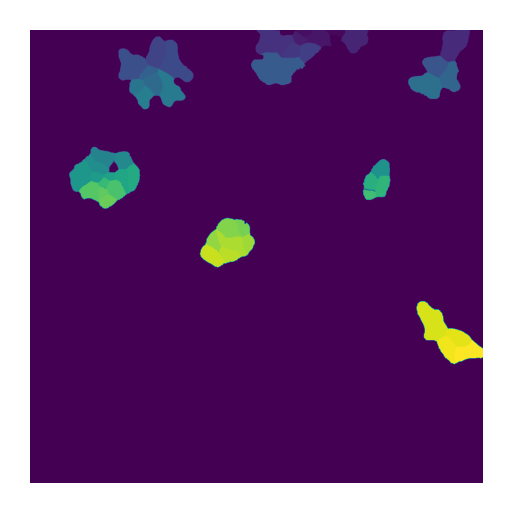

In [20]:
# check the output of the above step

import pylab
pylab.rcParams['figure.figsize'] = (2.0, 2.0)

file_name = "HEK_0019_merged"

mergeMasks=skimage.io.imread(save_dir + "/mergeMasks/" + file_name + "_mergeMasks"+".png")
plt.imshow(mergeMasks); plt.axis('off')

(-0.5, 1103.5, 1103.5, -0.5)

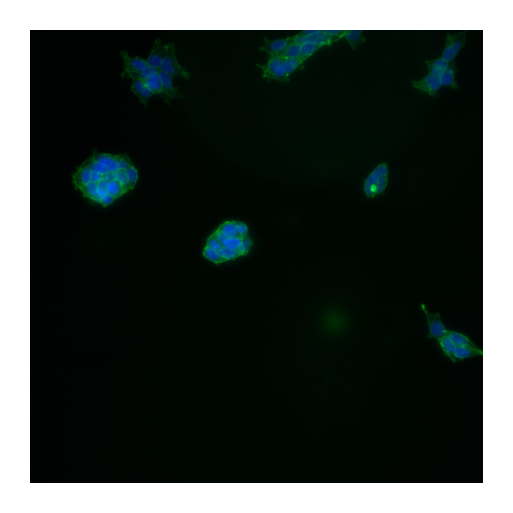

In [21]:
#compare to image

image=skimage.io.imread(input_dir + file_name + ".png")
plt.imshow(image); plt.axis('off')

In [ ]:
# create zip file to download a large chunk of data from kaggle (if needed)

!zip -r annotations_HEK.zip "../working"